In [72]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from esda import Moran
from splot.esda import plot_moran
from esda.moran import Moran_Local
from libpysal.weights import KNN
from splot.esda import lisa_cluster
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
import numpy as np

In [8]:
# For high streets in London
high_streets = gpd.read_file("GLA_High_Street_boundaries.gpkg")
high_streets = high_streets[['highstreet_name', 'geometry']]

print(high_streets.head())

                          highstreet_name  \
0                 Pimlico Road, Belgravia   
1  Queensway, Westbourne Grove, Bayswater   
2            Carshalton Road, Carshalton.   
3                  Mitcham Road, Croydon.   
4               Bridge Road, Chessington.   

                                            geometry  
0  POLYGON ((528532.653 178503.913, 528533.610 17...  
1  POLYGON ((525909.685 181229.993, 525902.809 18...  
2  POLYGON ((527372.837 164353.214, 527376.960 16...  
3  POLYGON ((531381.957 166498.580, 531386.088 16...  
4  POLYGON ((518643.379 164208.685, 518642.422 16...  


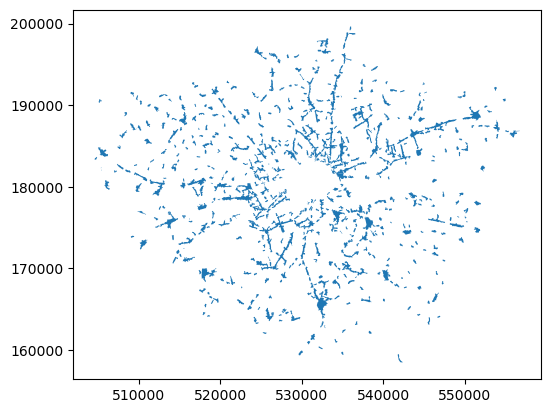

In [7]:
high_streets.plot()
plt.show()


In [14]:
# For income
imd_data = gpd.read_file("IMD_2019.shp")
# Only take London's entries
income_score = imd_data[imd_data['LADcd'].str.startswith('E09')]
income_score = income_score[['lsoa11cd', 'IncScore', 'geometry']]

print(income_score.head())


    lsoa11cd  IncScore                                           geometry
0  E01000001     0.007  POLYGON ((532105.092 182011.230, 532162.491 18...
1  E01000002     0.034  POLYGON ((532746.813 181786.891, 532671.688 18...
2  E01000003     0.086  POLYGON ((532135.145 182198.119, 532158.250 18...
3  E01000005     0.211  POLYGON ((533807.946 180767.770, 533649.063 18...
4  E01000006     0.117  POLYGON ((545122.049 184314.931, 545271.917 18...


In [15]:
print(income_score.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 4835 entries, 0 to 32821
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   lsoa11cd  4835 non-null   object  
 1   IncScore  4835 non-null   float64 
 2   geometry  4835 non-null   geometry
dtypes: float64(1), geometry(1), object(1)
memory usage: 151.1+ KB
None


In [16]:
# For economic activity
economic_activity = pd.read_csv("Economic Activity.csv")
economic_activity = economic_activity[['LSOA code', 'Economically active: Employee: Full-time']]

economic_activity.rename(columns={'LSOA code': 'lsoa11cd', 'Economically active: Employee: Full-time': 'FullTimeEmployees'}, inplace=True)

print(economic_activity.head())


    lsoa11cd  FullTimeEmployees
0  E01000001                573
1  E01000002                593
2  E01000003                677
3  E01000005                328
4  E01032739                922


In [17]:
print(economic_activity.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4994 entries, 0 to 4993
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   lsoa11cd           4994 non-null   object
 1   FullTimeEmployees  4994 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 78.2+ KB
None


In [18]:
# Merge data
economic_activity_gdf = gpd.GeoDataFrame(economic_activity)
merged_data = pd.merge(income_score, economic_activity_gdf, on='lsoa11cd', how='inner')

print(merged_data.head())

    lsoa11cd  IncScore                                           geometry  \
0  E01000001     0.007  POLYGON ((532105.092 182011.230, 532162.491 18...   
1  E01000002     0.034  POLYGON ((532746.813 181786.891, 532671.688 18...   
2  E01000003     0.086  POLYGON ((532135.145 182198.119, 532158.250 18...   
3  E01000005     0.211  POLYGON ((533807.946 180767.770, 533649.063 18...   
4  E01000006     0.117  POLYGON ((545122.049 184314.931, 545271.917 18...   

   FullTimeEmployees  
0                573  
1                593  
2                677  
3                328  
4                413  


In [19]:
print(merged_data.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4659 entries, 0 to 4658
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   lsoa11cd           4659 non-null   object  
 1   IncScore           4659 non-null   float64 
 2   geometry           4659 non-null   geometry
 3   FullTimeEmployees  4659 non-null   int64   
dtypes: float64(1), geometry(1), int64(1), object(1)
memory usage: 145.7+ KB
None


## Moran & LISA analysis for income score

/Users/liyuanyuanyuan/opt/anaconda3/envs/mscui2023/lib/python3.9/site-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/Users/liyuanyuanyuan/opt/anaconda3/envs/mscui2023/lib/python3.9/site-packages/splot/_viz_esda_mpl.py:354: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(moran.sim, shade=shade, color=color, ax=ax, **kwargs)


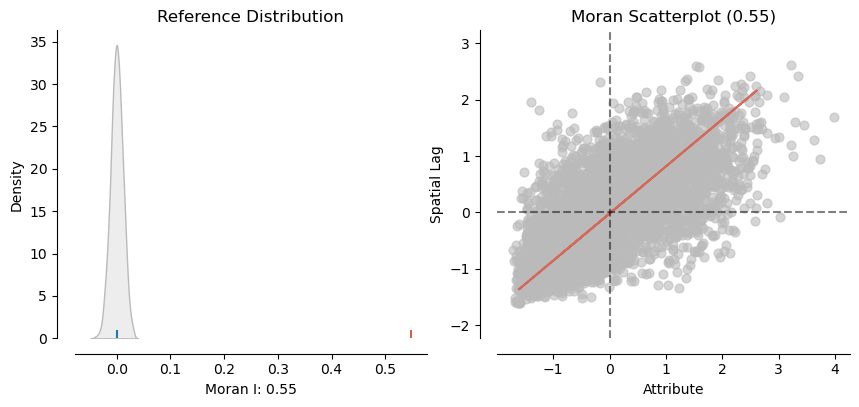

In [47]:

y = merged_data['IncScore'].values

w_knn = KNN.from_dataframe(merged_data, k=3)
w_knn.transform = 'r'  
moran = Moran(y, w_knn)

plot_moran(moran)

plt.savefig('Moran-Income.png', dpi=300, bbox_inches='tight')
plt.show()

/Users/liyuanyuanyuan/opt/anaconda3/envs/mscui2023/lib/python3.9/site-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/Users/liyuanyuanyuan/opt/anaconda3/envs/mscui2023/lib/python3.9/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


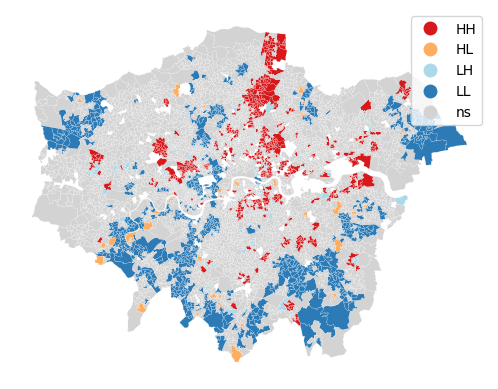

In [49]:

y = merged_data['IncScore'].values

w_knn = KNN.from_dataframe(merged_data, k=3)
w_knn.transform = 'r' 
moran_loc = Moran_Local(y, w_knn)

fig = lisa_cluster(moran_loc, merged_data)
plt.savefig('LISA-Income.png', dpi=300, bbox_inches='tight')
plt.show()

## Moran & LISA analysis for full time employees

/Users/liyuanyuanyuan/opt/anaconda3/envs/mscui2023/lib/python3.9/site-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/Users/liyuanyuanyuan/opt/anaconda3/envs/mscui2023/lib/python3.9/site-packages/splot/_viz_esda_mpl.py:354: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(moran.sim, shade=shade, color=color, ax=ax, **kwargs)


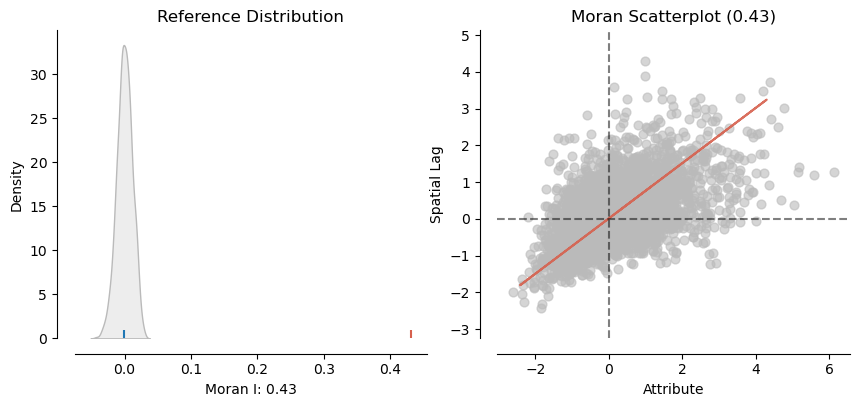

In [50]:
y = merged_data['FullTimeEmployees'].values

w_knn = KNN.from_dataframe(merged_data, k=3)
w_knn.transform = 'r'  # 行标准化权重
moran = Moran(y, w_knn)

plot_moran(moran)

plt.savefig('Moran-Employees.png', dpi=300, bbox_inches='tight')
plt.show()

/Users/liyuanyuanyuan/opt/anaconda3/envs/mscui2023/lib/python3.9/site-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/Users/liyuanyuanyuan/opt/anaconda3/envs/mscui2023/lib/python3.9/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


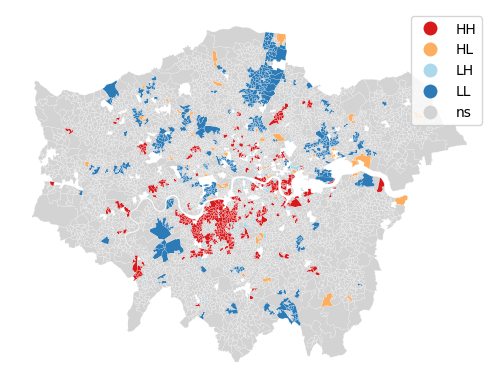

In [51]:
y = merged_data['FullTimeEmployees'].values

w_knn = KNN.from_dataframe(merged_data, k=3)
w_knn.transform = 'r'  # 行标准化权重
moran_loc = Moran_Local(y, w_knn)

fig2 = lisa_cluster(moran_loc, merged_data)
plt.savefig('LISA-Employees.png', dpi=300, bbox_inches='tight')
plt.show()

# Spatial Join

In [57]:

london_data = gpd.sjoin(merged_data, high_streets, how='left', predicate='intersects')
if merged_data.crs != high_streets.crs:
    high_streets = high_streets.to_crs(merged_data.crs)

In [73]:
print(london_data.head())

    lsoa11cd  IncScore                                           geometry  \
0  E01000001     0.007  POLYGON ((532105.092 182011.230, 532162.491 18...   
1  E01000002     0.034  POLYGON ((532746.813 181786.891, 532671.688 18...   
2  E01000003     0.086  POLYGON ((532135.145 182198.119, 532158.250 18...   
3  E01000005     0.211  POLYGON ((533807.946 180767.770, 533649.063 18...   
4  E01000006     0.117  POLYGON ((545122.049 184314.931, 545271.917 18...   

   FullTimeEmployees  index_right         highstreet_name  
0                573          NaN          Non-Highstreet  
1                593          NaN          Non-Highstreet  
2                677          NaN          Non-Highstreet  
3                328          NaN          Non-Highstreet  
4                413        576.0  North Street, Barking.  


In [60]:
print(london_data.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 5420 entries, 0 to 4658
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   lsoa11cd           5420 non-null   object  
 1   IncScore           5420 non-null   float64 
 2   geometry           5420 non-null   geometry
 3   FullTimeEmployees  5420 non-null   int64   
 4   index_right        3680 non-null   float64 
 5   highstreet_name    5420 non-null   object  
dtypes: float64(2), geometry(1), int64(1), object(2)
memory usage: 296.4+ KB
None


In [59]:
london_data.fillna(value={'highstreet_name': 'Non-Highstreet'}, inplace=True)


In [61]:
london_data.to_csv('combined_data.csv', index=False)


## Visualisation

/Users/liyuanyuanyuan/opt/anaconda3/envs/mscui2023/lib/python3.9/site-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/Users/liyuanyuanyuan/opt/anaconda3/envs/mscui2023/lib/python3.9/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


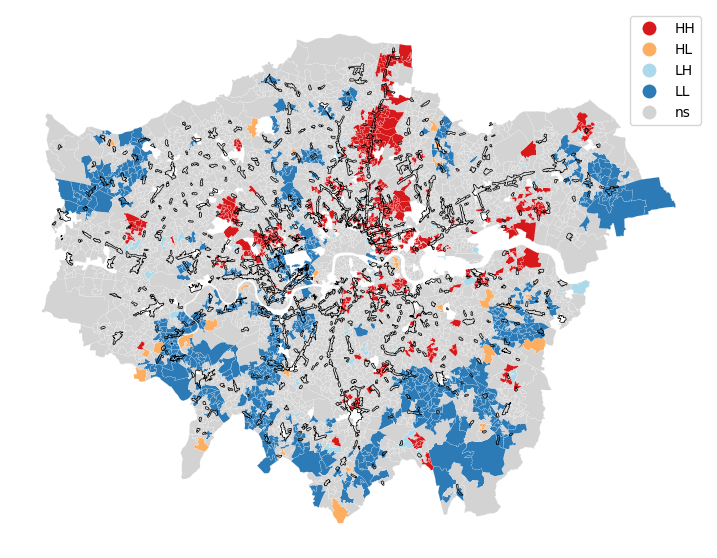

In [63]:
y = merged_data['IncScore'].values
w_knn = KNN.from_dataframe(merged_data, k=3)
w_knn.transform = 'r'
moran_loc = Moran_Local(y, w_knn)

fig, ax = lisa_cluster(moran_loc, merged_data, p=0.05, figsize=(9, 9))

high_streets.plot(ax=ax, facecolor='none', edgecolor='black', linewidths=0.5)

plt.savefig('LISA_income_with_HighStreets.png', dpi=300, bbox_inches='tight')
plt.show()

/Users/liyuanyuanyuan/opt/anaconda3/envs/mscui2023/lib/python3.9/site-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/Users/liyuanyuanyuan/opt/anaconda3/envs/mscui2023/lib/python3.9/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


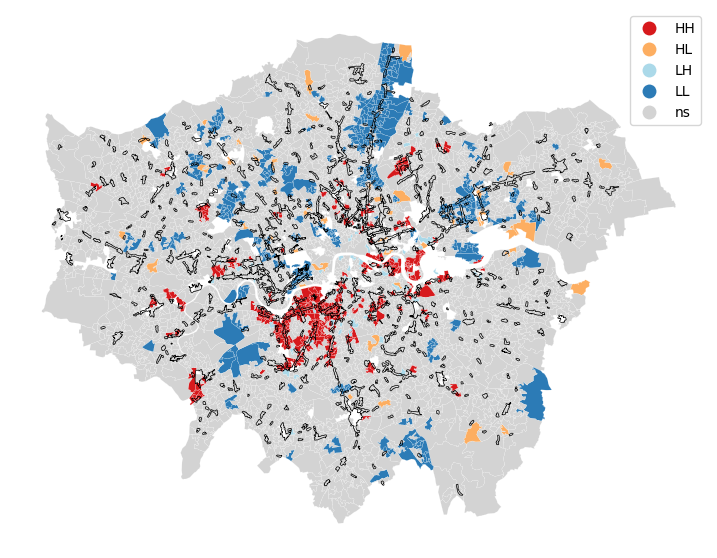

In [65]:
y = merged_data['FullTimeEmployees'].values
w_knn = KNN.from_dataframe(merged_data, k=3)
w_knn.transform = 'r'
moran_loc = Moran_Local(y, w_knn)

fig4, ax = lisa_cluster(moran_loc, merged_data, p=0.05, figsize=(9, 9))

high_streets.plot(ax=ax, facecolor='none', edgecolor='black', linewidths=0.5)

plt.savefig('LISA_employees_with_HighStreets.png', dpi=300, bbox_inches='tight')
plt.show()

/Users/liyuanyuanyuan/opt/anaconda3/envs/mscui2023/lib/python3.9/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


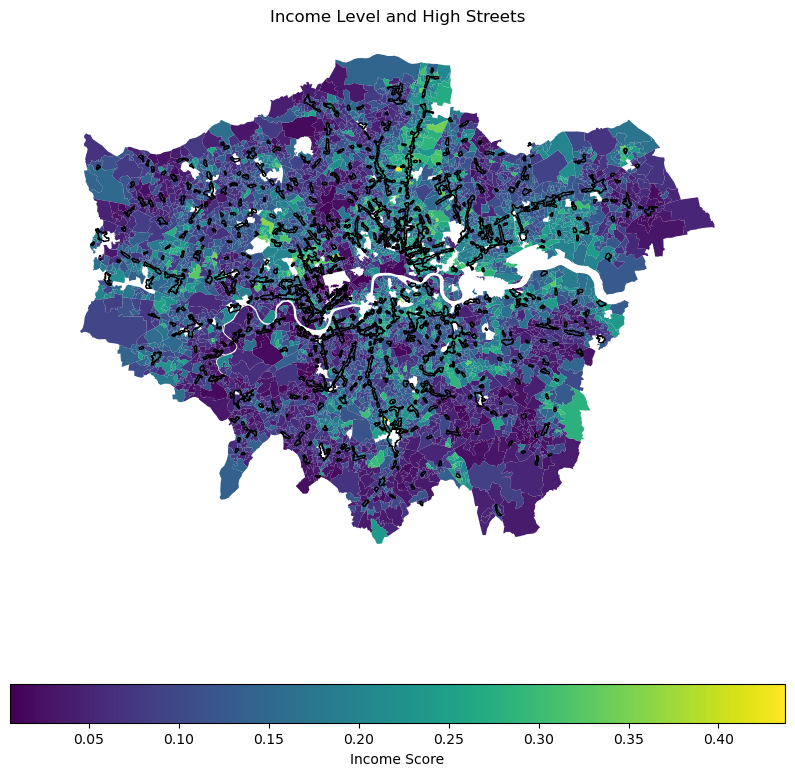

In [64]:
fig3, ax = plt.subplots(1, 1, figsize=(10, 10))
merged_data.plot(column='IncScore', ax=ax, legend=True,
                 legend_kwds={'label': "Income Score", 'orientation': "horizontal"})

high_streets.plot(ax=ax, color='none', edgecolor='black')
ax.set_title('Income Level and High Streets')
ax.set_axis_off()

plt.savefig('Income_and_High_Streets_Map.png', dpi=300)
plt.show()

/Users/liyuanyuanyuan/opt/anaconda3/envs/mscui2023/lib/python3.9/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


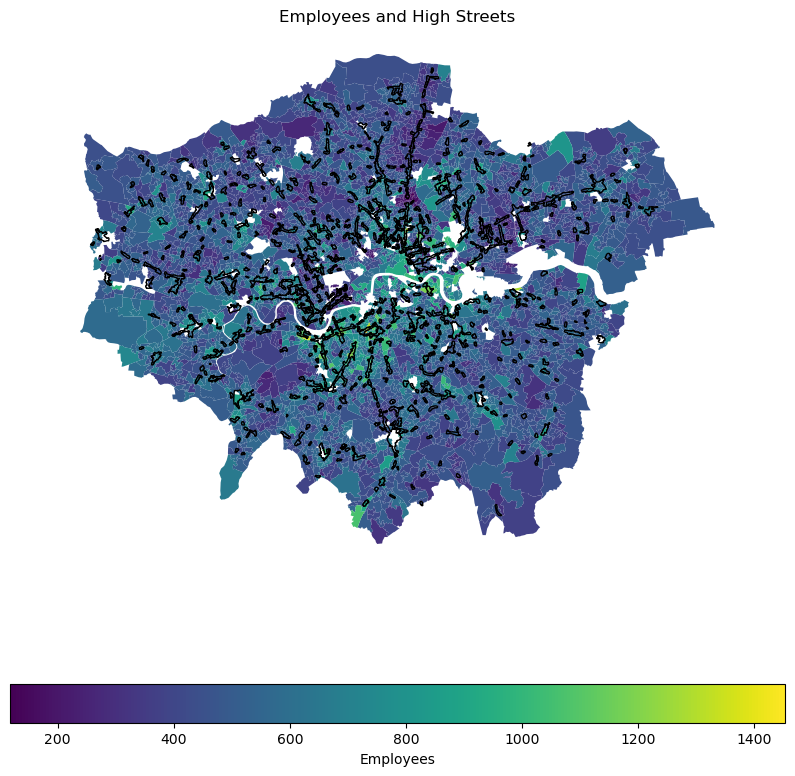

In [66]:
fig5, ax = plt.subplots(1, 1, figsize=(10, 10))
merged_data.plot(column='FullTimeEmployees', ax=ax, legend=True,
                 legend_kwds={'label': "Employees", 'orientation': "horizontal"})

high_streets.plot(ax=ax, color='none', edgecolor='black')
ax.set_title('Employees and High Streets')
ax.set_axis_off()

plt.savefig('Employees_and_High_Streets_Map.png', dpi=300)
plt.show()

## GWR (Geographically Weighted Regression) analysis

In [76]:
london_data['HighStreetPresence'] = (london_data['highstreet_name'] != "Non-Highstreet").astype(int)
london_data['const'] = 1
X = london_data[['const', 'IncScore', 'FullTimeEmployees']].values
y = london_data['HighStreetPresence'].values.reshape((-1, 1))

london_data['centroid'] = london_data.geometry.centroid
coords = np.array(list(zip(london_data.centroid.x, london_data.centroid.y)))
bw = Sel_BW(coords, y, X, fixed=False).search()
print("Optimal bandwidth:", bw)


Optimal bandwidth: 50.0


In [77]:
gwr_model = GWR(coords, y, X, bw)
gwr_results = gwr_model.fit()
print(gwr_results.summary())

Model type                                                         Gaussian
Number of observations:                                                5420
Number of covariates:                                                     3

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           1138.585
Log-likelihood:                                                   -3462.208
AIC:                                                               6930.416
AICc:                                                              6932.423
BIC:                                                             -45435.974
R2:                                                                   0.036
Adj. R2:                                                              0.036

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

/Users/liyuanyuanyuan/opt/anaconda3/envs/mscui2023/lib/python3.9/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


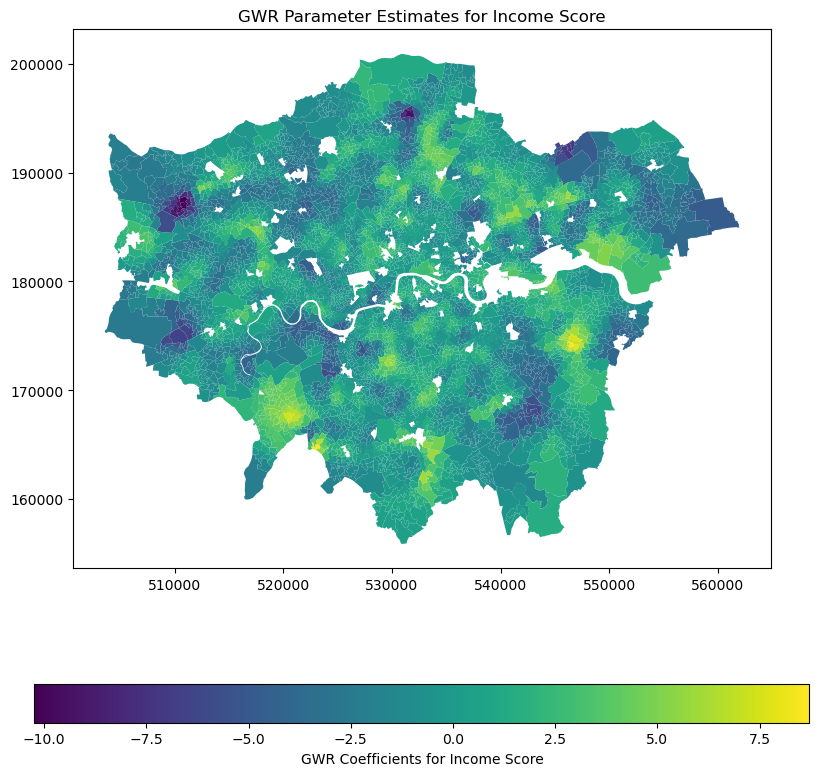

In [78]:
london_data['gwr_params_IncScore'] = gwr_results.params[:, 1]
fig6, ax = plt.subplots(figsize=(10, 10))
london_data.plot(column='gwr_params_IncScore', ax=ax, legend=True,
                 legend_kwds={'label': "GWR Coefficients for Income Score", 'orientation': "horizontal"})
plt.title('GWR Parameter Estimates for Income Score')
plt.savefig('GWR.png', dpi=300)
plt.show()


In [79]:
t_values = gwr_results.params[:, 1:] / gwr_results.bse[:, 1:] 
t_crit = 1.96 
significant_positive = (t_values > t_crit) & (gwr_results.params[:, 1:] > 0)

london_data['significant_inc'] = significant_positive[:, 0]  
london_data['significant_emp'] = significant_positive[:, 1]  


In [80]:
positive_areas = london_data[(london_data['significant_inc']) & (london_data['significant_emp'])]
print(positive_areas[['lsoa11cd', 'highstreet_name']])


       lsoa11cd            highstreet_name
285   E01000299  High Road, Woodside Park.
367   E01000382             Non-Highstreet
368   E01000383             Non-Highstreet
369   E01000384       High Street, Sidcup.
370   E01000385       Sidcup Hill, Sidcup.
...         ...                        ...
4651  E01033739             Non-Highstreet
4652  E01033740             Non-Highstreet
4653  E01033741             Non-Highstreet
4654  E01033742             Non-Highstreet
4656  E01033744             Non-Highstreet

[183 rows x 2 columns]


/Users/liyuanyuanyuan/opt/anaconda3/envs/mscui2023/lib/python3.9/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):
/Users/liyuanyuanyuan/opt/anaconda3/envs/mscui2023/lib/python3.9/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


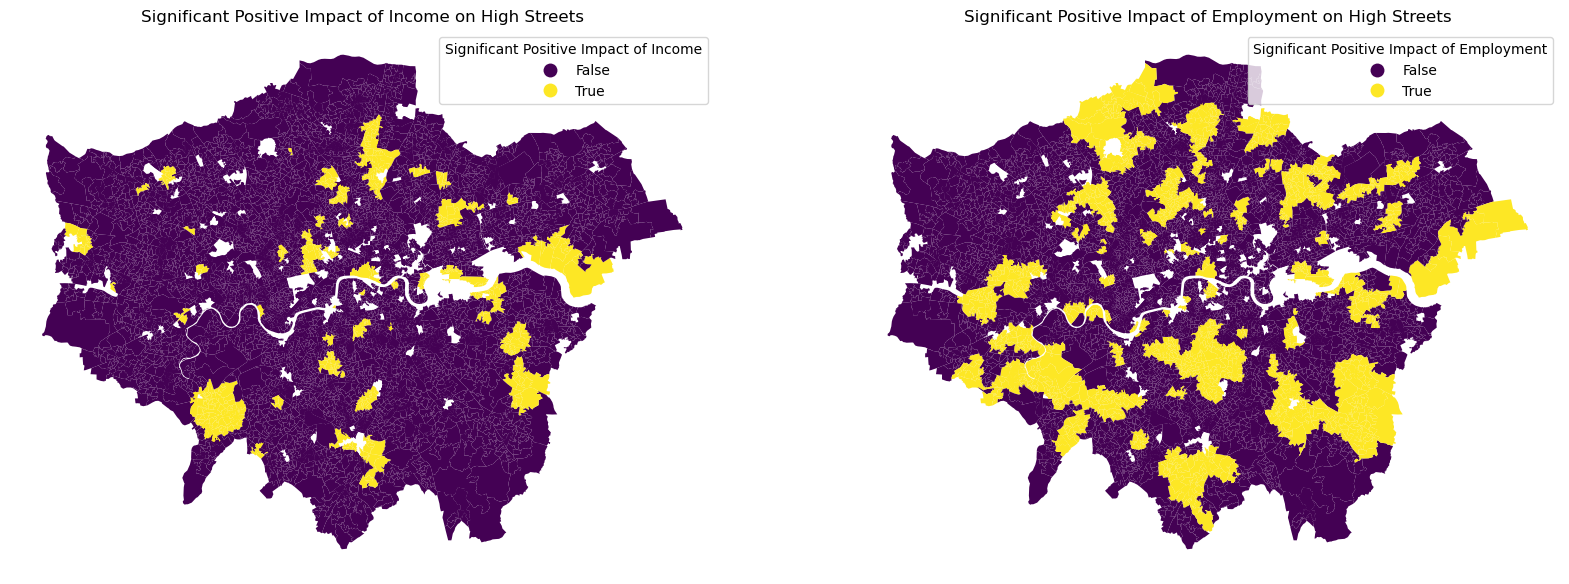

In [83]:
fig7, ax = plt.subplots(1, 2, figsize=(20, 10))

income_plot = london_data.plot(column='significant_inc', ax=ax[0], legend=True, cmap='viridis')
ax[0].set_title('Significant Positive Impact of Income on High Streets')
ax[0].set_axis_off()

income_legend = income_plot.get_legend()
income_legend.set_title('Significant Positive Impact of Income')

employment_plot = london_data.plot(column='significant_emp', ax=ax[1], legend=True, cmap='viridis')
ax[1].set_title('Significant Positive Impact of Employment on High Streets')
ax[1].set_axis_off()

employment_legend = employment_plot.get_legend()
employment_legend.set_title('Significant Positive Impact of Employment')
plt.savefig('Areas_with_Significant_Impact.png', dpi=300, bbox_inches='tight')
plt.show()
